# Premier League predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path='C:/Users/110927/Desktop/EstructuraDirectorio/03_MACHINE_LEARNING/CASOS/Premier league'
path=path.replace("\\", "/")

Datasets de la premier league de los ultimos 3 años, organizados por partidos, más datasets de estadisticas colectivas por equipos, como el valor de mercado de los jugadores y otros datos.

In [13]:
df20=pd.read_csv(path+'/DATOS/2020-2021.csv')
df21=pd.read_csv(path+'/DATOS/2021-2022.csv')
df22=pd.read_csv(path+'/DATOS/epl_results_2022-23.csv')
df21=df21[df22.columns.to_list()]
df20=df20[df22.columns.to_list()]
mv20=pd.read_excel(path+'/DATOS/mv2021.xlsx')
mv21=pd.read_excel(path+'/DATOS/MV2122.xlsx')
mv22=pd.read_excel(path+'/DATOS/MV2223.xlsx')

Hasta ahora tenía el dataset organizado por partidos, pero creo más conveniente organizarlo todo por equipo, para poder hacer acumulados y clasificaciones, por lo que duplicaré el número de registros del dataset y de esta forma quedará organizado por equipo. 

También añadiré otra variable que representará si el partido es local o visitante. 

Cambiaré el equipo visitante por equipo contrario.

In [14]:
def merge_season_data(df, mv, season):
    df_H = pd.merge(df, mv, how='left', left_on='HomeTeam', right_on='Team')
    df_H['Team'] = df_H['HomeTeam']
    df_H['A_or_H'] = 'H'
    df_H['AgainstTeam'] = df_H['AwayTeam']

    df_A = pd.merge(df, mv, how='left', left_on='AwayTeam', right_on='Team')
    df_A['Team'] = df_A['AwayTeam']
    df_A['A_or_H'] = 'A'
    df_A['AgainstTeam'] = df_A['HomeTeam']

    df_ = pd.concat([df_A, df_H], axis=0)
    df_['Season'] = season
    return df_
df_list = []

for season, df_season, mv_season in zip(['20/21', '21/22', '22/23'], [df20, df21, df22], [mv20, mv21, mv22]):
    df_season_merged = merge_season_data(df_season, mv_season, season)
    df_list.append(df_season_merged)

df = pd.concat(df_list, axis=0)[['Date', 'Time', 'Season', 'Team', 'A_or_H', 'AgainstTeam', 'FTHG', 'FTAG', 'FTR', 'Number_pl', 'Age_pls', 'MV_median', 'MV', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']]
df.Date=pd.to_datetime(df['Date'],format='%d/%m/%Y')

Saco los valores de las fechas y estandarizo las horas de los partidos

In [15]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek  # 0 representa el lunes, 6 representa el domingo
df['DayYear'] = df['Date'].dt.dayofyear
df['WeekYear'] = df['Date'].dt.isocalendar().week
df.loc[df.Time=='19:45','Time']='20:00'
df.loc[df.Time=='20:15','Time']='20:00'
df.loc[df.Time=='19:15','Time']='19:00'
df.loc[df.Time=='14:15','Time']='14:00'
df.loc[df.Time=='14:05','Time']='14:00'
df.loc[df.Time=='13:30','Time']='14:00'
df.loc[df.Time=='17:45','Time']='18:00'
df.loc[df.Time=='15:30','Time']='15:00'
df.loc[df.Time=='16:15','Time']='16:00'

Creo las variables que representan los puntos por resultado, los puntos acumulados, los puntos acumulados de los 5 ultimos partidos, puntos del último partido:

In [16]:
df.reset_index(inplace=True, drop=True)

df['MatchPoints'] = np.where(df['FTR'] == df['A_or_H'], 3, np.where(df['FTR'] == 'D', 1, 0))
df['PointsCounter'] = df.sort_values(by=['Season', 'Year', 'Month', 'Day'])\
                        .groupby(['Season', 'Team'])['MatchPoints'].cumsum()

df['Last5_Run'] = df.groupby(['Season', 'Team'])['MatchPoints']\
                    .shift(1).rolling(window=5, min_periods=1).sum().fillna(0)
df['LastMatch'] = df.groupby(['Season', 'Team'])['MatchPoints'].shift(1).fillna(0)
df=df.sort_values(by=['Season','Year', 'Month', 'Day'])

Genero una variable que será la jornada

In [ ]:
df['Week'] = df.sort_values(by=['Season', 'Year', 'Month', 'Day'])\
                    .groupby(['Season', 'Team']).cumcount() + 1

Otro paso de transformar el dataset por equipo es convertir las estadisticas que estaban por local/visitante ahora las convierto en acumulados por equipo.

In [ ]:
df_cum=df.groupby(['Season','Team','A_or_H'])['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
                                              'AC', 'HY', 'AY', 'HR', 'AR'].cumsum()
df['Shots']=df_cum['HS']+df_cum['AS']
df['TargetShots']=df_cum['HST']+df_cum['AST']
df['Corners']=df_cum['HC']+df_cum['AC']
df['FouldComm']=df_cum['HF']+df_cum['AF']
df['YellowCards']=df_cum['HY']+df_cum['AY']
df['RedCards']=df_cum['HR']+df_cum['AR']

Organizo el dataset

In [19]:
df=df[['Time','Season','Week','Team','A_or_H','AgainstTeam','MatchPoints','PointsCounter',
       'LastMatch','Last5_Run','FTHG','FTAG', 'FTR','Year','Month','Day','Shots','TargetShots',
       'Corners','FouldComm','YellowCards','RedCards' ,'Weekday','DayYear',
       'WeekYear', 'Number_pl', 'Age_pls','MV_median', 'MV', 'HTHG', 'HTAG', 'HTR', 'Referee' ]]
df=pd.concat([df,df_cum], axis=1)

Aqui estoy tratando de arreglar un problema surgido con la variable semana que no se está calculando correctamente para los equipos contrarios (WorkInProgress)

In [42]:
equipos = df[df['Season'] == '20/21']['Team'].unique()

for team in equipos:
    for opponent in equipos:
        if team != opponent:
            mask = (df['Team'] == team) & (df['AgainstTeam'] == opponent)
            indices = df.loc[mask].index
            for idx in indices:
                df.loc[idx, 'Week'] = df.loc[df['Team'] == team, 'Week'].values[0]  # Asigna solo el primer valor de 'Week'




Comprobaciones

In [ ]:
df[(df['Season']=='20/21')&(df['AgainstTeam']=='Arsenal')][['Season','Year', 'Month', 'Day', 'Week','PointsCounter']]

In [22]:
df[(df['Season']=='20/21')&(df['AgainstTeam']=='Man United')]\
                                [['Season','Year', 'Month', 'Day', 'Week','PointsCounter']]

,Season,Year,Month,Day,Week,PointsCounter
10,20/21,2020,9,19,2,6
398,20/21,2020,9,26,3,3
36,20/21,2020,10,4,4,7
421,20/21,2020,10,17,5,7
51,20/21,2020,10,24,6,9
64,20/21,2020,11,1,7,12
450,20/21,2020,11,7,8,13
81,20/21,2020,11,21,9,3
473,20/21,2020,11,29,10,17
480,20/21,2020,12,5,11,17


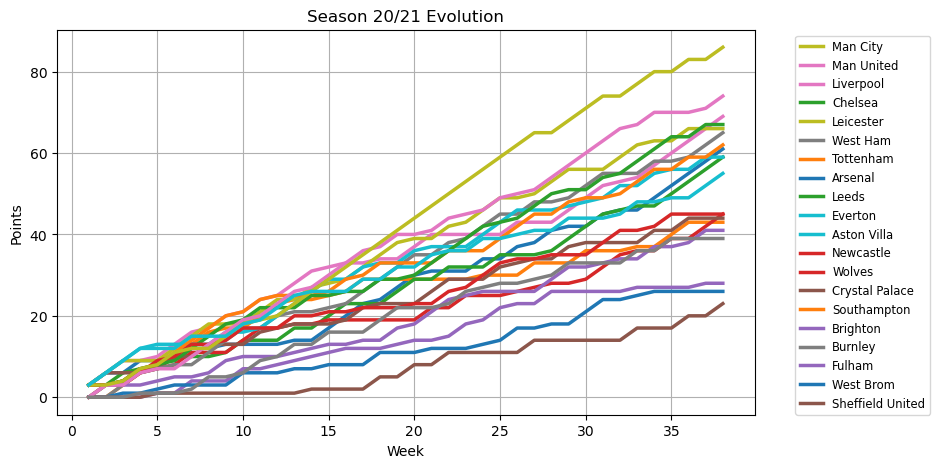

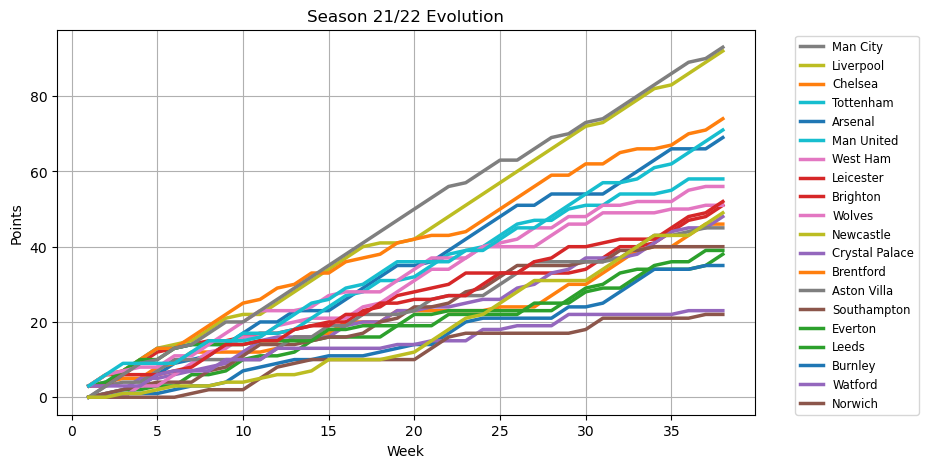

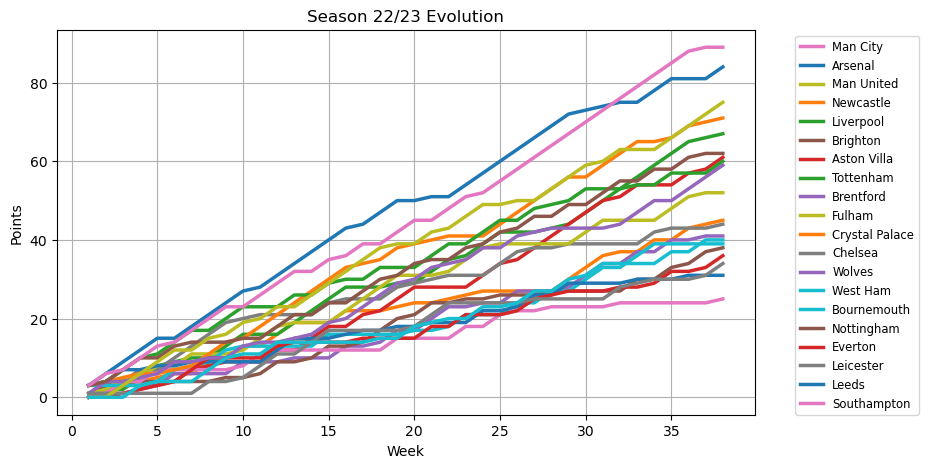

In [83]:
#Seasons=df['Season'].unique()
#
#for season in Seasons:
#    equipos = df[df['Season']==season]['Team'].unique()
#    plt.figure(figsize=(9,5))
#    
#    for equipo in equipos:
#        datos_equipo = df[(df['Season']==season) & (df['Team']==equipo)]
#        plt.plot(datos_equipo['Week'], datos_equipo['PointsCounter'], label=equipo, 
#                 linestyle='-',  linewidth=2.5)
#
#    plt.xlabel('Week')
#    plt.ylabel('Points')
#    plt.title('Season '+ season + ' Evolution')
#    handles, labels = plt.gca().get_legend_handles_labels()
#    sorted_labels = sorted(labels, 
#                           key=lambda x: df[(df['Season'] == season) 
#                        & (df['Team'] == x)]['PointsCounter'].max(), reverse=True)
#    handles = [handles[labels.index(label)] for label in sorted_labels]
#    plt.legend(handles, sorted_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
#    # Mostrar la gráfica
#    plt.grid(True)


In [150]:
df.to_pickle('PLSinProcesar.pickle')